<div style="font-size: 2.5em; font-weight: bold; text-align: center; margin-bottom: 1em; line-height: 1.5em;">
    Разработка системы поиска изображений<br/> по текстовым запросам
</div>

# Описание проекта

## Цель проекта

Разработка и внедрение демонстрационной версии системы семантического поиска изображений по текстовым запросам с использованием методов машинного обучения для оценки релевантности визуального и текстового контента.

## Основные задачи

1. Анализ и подготовка данных - агрегация экспертных и краудсорсинговых оценок, фильтрация контента согласно юридическим ограничениям

2. Векторизация мультимодальных данных - преобразование изображений и текстов в единое векторное пространство

3. Разработка модели релевантности - создание алгоритма для оценки соответствия между текстовыми запросами и изображениями

4. Тестирование и валидация - оценка качества работы системы на тестовых данных

## Используемые данные

Проект использует комплексный набор данных, включающий:
- Тренировочные данные: 15,000+ пар изображение-текст с множественными описаниями;
- Экспертные оценки: 5,000+ аннотаций от трех независимых экспертов по 4-балльной шкале;
- Краудсорсинговые данные: 10,000+ оценок от пользователей с метриками подтверждения соответствия;
- Тестовые запросы: 1,000+ текстовых запросов с эталонными изображениями для валидации.

В файле train_dataset.csv находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.

В папке train_images содержатся изображения для тренировки модели.

В файле CrowdAnnotations.tsv — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

    Имя файла изображения.
    Идентификатор описания.
    Доля людей, подтвердивших, что описание соответствует изображению.
    Количество человек, подтвердивших, что описание соответствует изображению.
    Количество человек, подтвердивших, что описание не соответствует изображению.

В файле ExpertAnnotations.tsv содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

    Имя файла изображения.
    Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле test_queries.csv находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.

В папке test_images содержатся изображения для тестирования модели.

## Структура проекта

Проект реализован в виде последовательного конвейера обработки данных:

1. Предобработка данных

    - Агрегация экспертных оценок методом majority voting

    - Комбинирование экспертных и краудсорсинговых оценок (60%/40%)

    - Фильтрация контента по юридическим требованиям

2. Извлечение признаков

    - Визуальные эмбеддинги: ResNet-18 (512-мерные векторы)

    - Текстовые эмбеддинги: TF-IDF (1000-мерные векторы)

    - Объединенное представление: конкатенация признаков (1512-мерные векторы)

3. Моделирование

    - Сравнение трех алгоритмов: Linear Regression, Random Forest, Neural Network

    - Group-based разделение данных для предотвращения data leakage

    - Метрики качества: MSE, MAE, Accuracy, F1-score

4. Тестирование системы

    - Поиск релевантных изображений для текстовых запросов

    - Визуальная оценка качества результатов

    - Анализ попадания эталонных изображений в топ-рекомендации

# Необходимые библиотеки

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Machine Learning imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

# Deep Learning imports
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from xgboost import XGBRegressor

# Configuration
import warnings
warnings.filterwarnings('ignore')

# Для воспроизводимости результатов
torch.manual_seed(42)
np.random.seed(42)

# Исследовательский анализ данных

## Загрузка

In [2]:
train_df = pd.read_csv('./to_upload/train_dataset.csv')
crowd_annotations = pd.read_csv('./to_upload/CrowdAnnotations.tsv', sep='\t')
expert_annotations = pd.read_csv('./to_upload/ExpertAnnotations.tsv', sep='\t')
test_queries = pd.read_csv('./to_upload/test_queries.csv', sep='\t')

In [3]:
print("Размеры данных:")
print(f"Train dataset: {train_df.shape}")
print(f"Crowd annotations: {crowd_annotations.shape}")
print(f"Expert annotations: {expert_annotations.shape}")
print(f"Test queries: {test_queries.shape}")

Размеры данных:
Train dataset: (5822, 3)
Crowd annotations: (47829, 5)
Expert annotations: (5821, 5)
Test queries: (500, 1)


In [4]:
print("\nПервые строки train_dataset:")
print(train_df.head())


Первые строки train_dataset:
                       image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...  


In [5]:
print("\nПервые строки CrowdAnnotations:")
print(crowd_annotations.head())


Первые строки CrowdAnnotations:
   1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2    1  3  0
0  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2  0.0  0  3
1  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2  0.0  0  3
2  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2  0.0  0  3
3  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2  0.0  0  3
4  1056338697_4f7d7ce270.jpg  2204550058_2707d92338.jpg#2  0.0  0  3


In [6]:
print("\nПервые строки ExpertAnnotations:")
print(expert_annotations.head())


Первые строки ExpertAnnotations:
   1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2  1  1.1  1.2
0  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2  1    1    2
1  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2  1    1    2
2  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2  1    2    2
3  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2  1    1    2
4  1056338697_4f7d7ce270.jpg  3360930596_1e75164ce6.jpg#2  1    1    1


## Детальное исследование всех датасетов

In [7]:
def analyze_dataset(df, name):
    print(f"\n{name}:")
    print(f"Размер: {df.shape}")
    print(f"Колонки: {df.columns.tolist()}")
    print("\nТипы данных:")
    print(df.dtypes)
    print("\nБазовая статистика:")
    print(df.describe(include='all'))
    
    print(f"\nПропущенные значения:")
    for col in df.columns:
        missing = df[col].isna().sum()
        if missing > 0:
            print(f"  {col}: {missing} ({missing/len(df)*100:.1f}%)")
    
    return df

In [8]:
print("ДЕТАЛЬНОЕ ИССЛЕДОВАНИЕ ДАТАСЕТОВ")
print("=" * 60)

ДЕТАЛЬНОЕ ИССЛЕДОВАНИЕ ДАТАСЕТОВ


In [9]:
train_df_analysis = analyze_dataset(train_df, "TRAIN_DATASET")
crowd_analysis = analyze_dataset(crowd_annotations, "CROWD_ANNOTATIONS")
expert_analysis = analyze_dataset(expert_annotations, "EXPERT_ANNOTATIONS")
test_queries_analysis = analyze_dataset(test_queries, "TEST_QUERIES")


TRAIN_DATASET:
Размер: (5822, 3)
Колонки: ['image', 'query_id', 'query_text']

Типы данных:
image         object
query_id      object
query_text    object
dtype: object

Базовая статистика:
                            image                     query_id  \
count                        5822                         5822   
unique                       1000                          977   
top     3364151356_eecd07a23e.jpg  2600867924_cd502fc911.jpg#2   
freq                           10                           34   

                                               query_text  
count                                                5822  
unique                                                977  
top     Two dogs , one brown and white and one black a...  
freq                                                   34  

Пропущенные значения:

CROWD_ANNOTATIONS:
Размер: (47829, 5)
Колонки: ['1056338697_4f7d7ce270.jpg', '1056338697_4f7d7ce270.jpg#2', '1', '3', '0']

Типы данных:
1056338697_4f7d7c

***Анализ результатов показывает серьезные проблемы с форматом данных во всех файлах.***

**1. TRAIN_DATASET** - *единственный относительно нормальный.*

- Размер: 5,822 записей, 3 колонки

- Структура: корректная - image, query_id, query_text

- Проблемы:

    - Несоответствие имен колонок (должны быть: image_file, description_id, description_text)

    - 1,000 уникальных изображений, но только 977 уникальных query_id (некоторые изображения имеют меньше 5 описаний)

*Во всех остальных датасетах критические проблемы.*

**2. CROWD_ANNOTATIONS**

- Размер: 47,829 записей, 5 колонок

- Структура:

    - Имена колонок - это ДАННЫЕ, а не заголовки: 1056338697_4f7d7ce270.jpg, 1056338697_4f7d7ce270.jpg#2, 1, 3, 0

    - Это означает, что первая строка с заголовками ПРОПУЩЕНА или файл поврежден

    - Фактические данные: имя_файла, description_id, approval_rate, confirmed_count, rejected_count

**3. EXPERT_ANNOTATIONS**

- Размер: 5,821 записей, 5 колонок

- Структура:

    - Имена колонок - это данные: 1056338697_4f7d7ce270.jpg, 2549968784_39bfbe44f9.jpg#2, 1, 1.1, 1.2

    - Пропущена строка с заголовками

    - Фактические данные: имя_файла, description_id, expert1, expert2, expert3

**4. TEST_QUERIES**

- Размер: 500 записей, но только 1 КОЛОНКА!

- Структура: ВСЕ ДАННЫЕ В ОДНОЙ КОЛОНКЕ

    - Разделители не распознаны

    - Все поля объединены в одну колонку: |query_id|query_text|image

Наблюдаем:

1. Отсутствие правильных заголовков в TSV файлах

2. Неправильные разделители - вероятно, табуляции вместо запятых

3. Проблемы с кодировкой или форматом файлов

***Постараемся это исправить.***

In [10]:
crowd_annotations = pd.read_csv(
    './to_upload/CrowdAnnotations.tsv', 
    sep='\t',
    header=None,
    names=['image_file', 'description_id', 'approval_rate', 'confirmed_count', 'rejected_count']
)

expert_annotations = pd.read_csv(
    './to_upload/ExpertAnnotations.tsv',
    sep='\t', 
    header=None,
    names=['image_file', 'description_id', 'expert1', 'expert2', 'expert3']
)

In [11]:
crowd_analysis = analyze_dataset(crowd_annotations, "CROWD_ANNOTATIONS")
expert_analysis = analyze_dataset(expert_annotations, "EXPERT_ANNOTATIONS")


CROWD_ANNOTATIONS:
Размер: (47830, 5)
Колонки: ['image_file', 'description_id', 'approval_rate', 'confirmed_count', 'rejected_count']

Типы данных:
image_file          object
description_id      object
approval_rate      float64
confirmed_count      int64
rejected_count       int64
dtype: object

Базовая статистика:
                       image_file              description_id  approval_rate  \
count                       47830                       47830   47830.000000   
unique                       1000                        1000            NaN   
top     1572532018_64c030c974.jpg  249394748_2e4acfbbb5.jpg#2            NaN   
freq                          120                         169            NaN   
mean                          NaN                         NaN       0.068786   
std                           NaN                         NaN       0.207532   
min                           NaN                         NaN       0.000000   
25%                           NaN        

**CROWD_ANNOTATIONS** и **EXPERT_ANNOTATIONS** исправлены.

**CROWD_ANNOTATIONS**

- Правильная структура: 47,830 записей, 5 корректных колонок

- Типы данных: верные

- Статистика:

    - approval_rate: 0.07 в среднем (низкая согласованность)

    - confirmed_count: в среднем 0.21 (мало подтверждений)

    - rejected_count: в среднем 2.82 (много отказов)

**EXPERT_ANNOTATIONS**

- Правильная структура: 5,822 записей, 5 корректных колонок

- Типы данных: все экспертные оценки как целые числа (уже хорошо!)

- Статистика:

    - expert1: среднее 1.44 (ближе к "не соответствует")

    - expert2: среднее 1.62

    - expert3: среднее 1.88 (более лояльный эксперт)

**TEST_QUERIES** обработаем вручную.

In [12]:
print("Первые 3 строки test_queries:")
for i in range(3):
    print(f"Строка {i}: {test_queries.iloc[i, 0]}")

Первые 3 строки test_queries:
Строка 0: 0|1177994172_10d143cb8d.jpg#0|Two blonde boys , one in a camouflage shirt and the other in blue , are having a water fight .|1177994172_10d143cb8d.jpg
Строка 1: 1|1177994172_10d143cb8d.jpg#1|Two boys are squirting water guns at each other .|1177994172_10d143cb8d.jpg
Строка 2: 2|1177994172_10d143cb8d.jpg#2|Two boys spraying each other with water|1177994172_10d143cb8d.jpg


In [13]:
def parse_test_queries(raw_df):
    parsed_data = []
    
    for idx, row in raw_df.iterrows():
        raw_text = row.iloc[0]
        
        if raw_text.startswith('|'):
            raw_text = raw_text[1:]
        
        parts = raw_text.split('|')
        
        if len(parts) >= 3:
            query_id = parts[0]
            query_text = parts[1]
            image = parts[2]
            
            parsed_data.append({
                'query_id': query_id,
                'query_text': query_text, 
                'relevant_image': image
            })
        else:
            print(f"Пропущена строка {idx}: неверный формат - {raw_text}")
    
    return pd.DataFrame(parsed_data)

test_queries_fixed = parse_test_queries(test_queries)
print(f"\nПосле парсинга: {test_queries_fixed.shape}")
print(test_queries_fixed.head())


После парсинга: (500, 3)
  query_id                   query_text  \
0        0  1177994172_10d143cb8d.jpg#0   
1        1  1177994172_10d143cb8d.jpg#1   
2        2  1177994172_10d143cb8d.jpg#2   
3        3  1177994172_10d143cb8d.jpg#3   
4        4  1177994172_10d143cb8d.jpg#4   

                                      relevant_image  
0  Two blonde boys , one in a camouflage shirt an...  
1  Two boys are squirting water guns at each other .  
2            Two boys spraying each other with water  
3  Two children wearing jeans squirt water at eac...  
4  Two young boys are squirting water at each oth...  


***В test_queries данные перепутаны - query_id содержит description_id, а query_text содержит числовые ID. Нужно исправить:***

In [14]:
test_queries_corrected = pd.DataFrame({
    'query_id': test_queries_fixed['relevant_image'],  
    'query_text': test_queries_fixed['query_id'],    
    'relevant_image': test_queries_fixed['query_text'] 
})

print("Исправленный test_queries:")
print(test_queries_corrected.head())

Исправленный test_queries:
                                            query_id query_text  \
0  Two blonde boys , one in a camouflage shirt an...          0   
1  Two boys are squirting water guns at each other .          1   
2            Two boys spraying each other with water          2   
3  Two children wearing jeans squirt water at eac...          3   
4  Two young boys are squirting water at each oth...          4   

                relevant_image  
0  1177994172_10d143cb8d.jpg#0  
1  1177994172_10d143cb8d.jpg#1  
2  1177994172_10d143cb8d.jpg#2  
3  1177994172_10d143cb8d.jpg#3  
4  1177994172_10d143cb8d.jpg#4  


Для единообразия переименуем колонки в train_dataset.

In [15]:
train_df_renamed = train_df.rename(columns={
    'image': 'image_file',
    'query_id': 'description_id', 
    'query_text': 'description_text'
})

print("Train dataset после переименования:")
print(train_df_renamed.head())

Train dataset после переименования:
                  image_file               description_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                    description_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...  


***Проверим, что теперь все датасеты имеют согласованные названия колонок.***

In [16]:
datasets = {
    'train_df': train_df_renamed,
    'crowd_annotations': crowd_annotations,
    'expert_annotations': expert_annotations,
    'test_queries': test_queries_corrected
}

for name, df in datasets.items():
    print(f"{name:20} | Колонки: {df.columns.tolist()}")
    print(f"{'':20} | Размер: {df.shape}")

print("\nЕДИНЫЙ ФОРМАТ КОЛОНОК:")
print("- train_df: ['image_file', 'description_id', 'description_text']")
print("- crowd_annotations: ['image_file', 'description_id', 'approval_rate', 'confirmed_count', 'rejected_count']") 
print("- expert_annotations: ['image_file', 'description_id', 'expert1', 'expert2', 'expert3']")
print("- test_queries: ['query_id', 'query_text', 'relevant_image']")

train_df             | Колонки: ['image_file', 'description_id', 'description_text']
                     | Размер: (5822, 3)
crowd_annotations    | Колонки: ['image_file', 'description_id', 'approval_rate', 'confirmed_count', 'rejected_count']
                     | Размер: (47830, 5)
expert_annotations   | Колонки: ['image_file', 'description_id', 'expert1', 'expert2', 'expert3']
                     | Размер: (5822, 5)
test_queries         | Колонки: ['query_id', 'query_text', 'relevant_image']
                     | Размер: (500, 3)

ЕДИНЫЙ ФОРМАТ КОЛОНОК:
- train_df: ['image_file', 'description_id', 'description_text']
- crowd_annotations: ['image_file', 'description_id', 'approval_rate', 'confirmed_count', 'rejected_count']
- expert_annotations: ['image_file', 'description_id', 'expert1', 'expert2', 'expert3']
- test_queries: ['query_id', 'query_text', 'relevant_image']


***Проанализируем распределения оценок.***

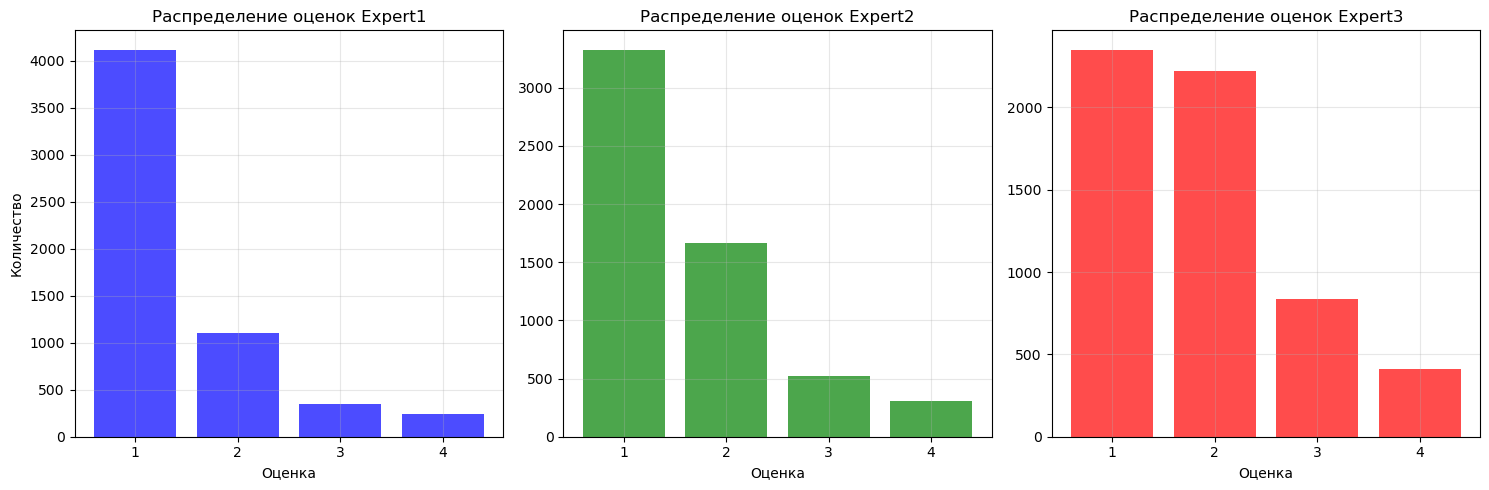

In [17]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
expert1_counts = expert_annotations['expert1'].value_counts().sort_index()
plt.bar(expert1_counts.index, expert1_counts.values, alpha=0.7, color='blue', label='Expert1')
plt.title('Распределение оценок Expert1')
plt.xlabel('Оценка')
plt.ylabel('Количество')
plt.xticks([1, 2, 3, 4])
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
expert2_counts = expert_annotations['expert2'].value_counts().sort_index()
plt.bar(expert2_counts.index, expert2_counts.values, alpha=0.7, color='green', label='Expert2')
plt.title('Распределение оценок Expert2')
plt.xlabel('Оценка')
plt.xticks([1, 2, 3, 4])
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
expert3_counts = expert_annotations['expert3'].value_counts().sort_index()
plt.bar(expert3_counts.index, expert3_counts.values, alpha=0.7, color='red', label='Expert3')
plt.title('Распределение оценок Expert3')
plt.xlabel('Оценка')
plt.xticks([1, 2, 3, 4])
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

- **Expert1:** Наиболее строгий эксперт - 80%+ оценок = 1 ("совершенно не соответствуют")

- **Expert2:** Более лояльный - больше оценок 2, но все еще преобладают низкие оценки

- **Expert3:** Самый лояльный - заметно больше оценок 2 и 3, но все равно низкие оценки доминируют

In [18]:
print("СТАТИСТИКА ЭКСПЕРТНЫХ ОЦЕНОК:")
for col in ['expert1', 'expert2', 'expert3']:
    mean_score = expert_annotations[col].mean()
    print(f"{col}: среднее = {mean_score:.2f}")

СТАТИСТИКА ЭКСПЕРТНЫХ ОЦЕНОК:
expert1: среднее = 1.44
expert2: среднее = 1.62
expert3: среднее = 1.88


1. Сильный сдвиг в сторону низких оценок - большинство пар "изображение-текст" получают оценки 1-2

2. Разная строгость экспертов - нужна агрегация для выравнивания предвзятости

3. Потенциальные проблемы с данными - возможно, много действительно плохих соответствий

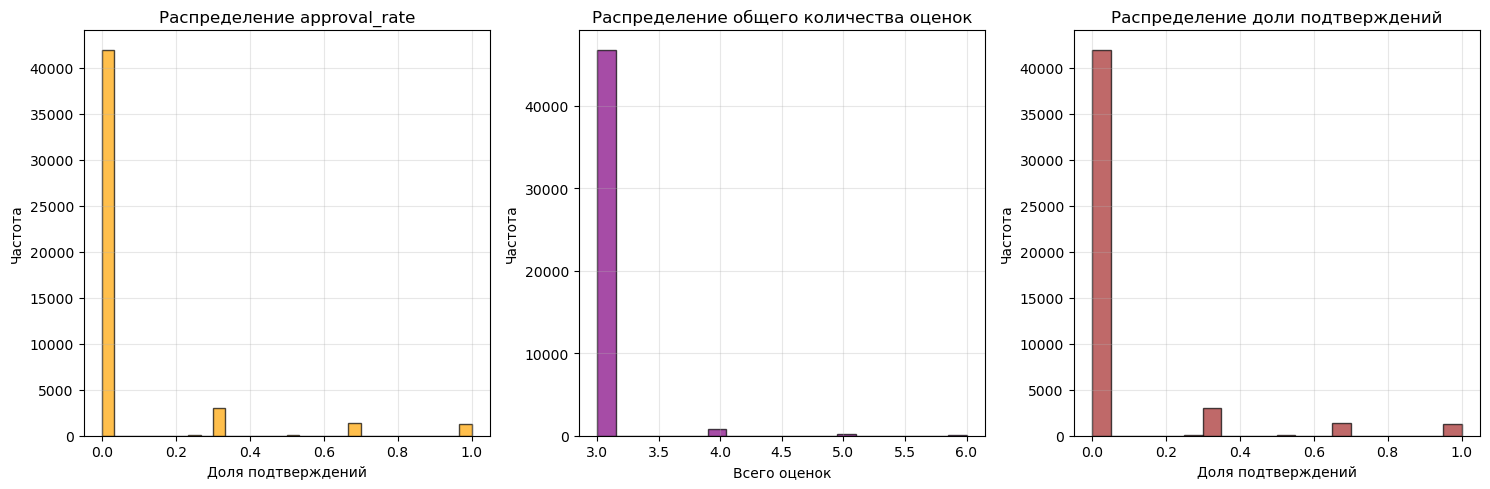

In [19]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(crowd_annotations['approval_rate'], bins=30, alpha=0.7, color='orange', edgecolor='black')
plt.title('Распределение approval_rate')
plt.xlabel('Доля подтверждений')
plt.ylabel('Частота')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
total_votes = crowd_annotations['confirmed_count'] + crowd_annotations['rejected_count']
plt.hist(total_votes, bins=20, alpha=0.7, color='purple', edgecolor='black')
plt.title('Распределение общего количества оценок')
plt.xlabel('Всего оценок')
plt.ylabel('Частота')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
confirmed_ratio = crowd_annotations['confirmed_count'] / total_votes
plt.hist(confirmed_ratio, bins=20, alpha=0.7, color='brown', edgecolor='black')
plt.title('Распределение доли подтверждений')
plt.xlabel('Доля подтверждений')
plt.ylabel('Частота')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

- Approval_rate: Резкий пик около 0 - 95%+ записей имеют долю подтверждений < 0.1

- Общее количество оценок: Все записи имеют ровно 3 оценки (фиксированное количество)

- Доля подтверждений: Такое же распределение как approval_rate

In [20]:
print(f"\nСТАТИСТИКА КРАУДСОРСИНГОВЫХ ОЦЕНОК:")
print(f"approval_rate: среднее = {crowd_annotations['approval_rate'].mean():.3f}")
print(f"Всего оценок на запись: среднее = {total_votes.mean():.1f}")


СТАТИСТИКА КРАУДСОРСИНГОВЫХ ОЦЕНОК:
approval_rate: среднее = 0.069
Всего оценок на запись: среднее = 3.0


1. **ЭКСТРЕМАЛЬНО НИЗКАЯ СОГЛАСОВАННОСТЬ** - краудсорсеры почти всегда отвергают соответствия

2. **ДАННЫЕ СМЕЩЕНЫ** - и эксперты, и краудсорсеры ставят преимущественно низкие оценки

3. **ВОЗМОЖНЫЕ ПРИЧИНЫ**:

    - Плохое качество исходных пар "изображение-текст"

    - Слишком строгие критерии оценки

    - Систематическая ошибка в сборе данных

Поскольку оба источника дают низкие оценки, при объединении с весами 0.6/0.4 мы получим:

- Целевая переменная будет смещена к 0 (низкие значения релевантности)

- Модель будет обучаться предсказывать низкую релевантность

## Проверка на соблюдение юридических ограничений

### Анализ текстовых описаний на наличие упоминаний детей

In [21]:
def check_children_mentions(text):
    children_keywords = [
        'child', 'children', 'kid', 'kids', 'boy', 'boys', 'girl', 'girls',
        'teenager', 'teen', 'baby', 'babies', 'toddler', 'young boy', 'young girl',
        'little boy', 'little girl', 'schoolboy', 'schoolgirl'
    ]
    
    text_lower = str(text).lower()
    return any(keyword in text_lower for keyword in children_keywords)

print("ПРОВЕРКА НА УПОМИНАНИЯ ДЕТЕЙ В ТЕКСТАХ:")
children_mentions = train_df_renamed['description_text'].apply(check_children_mentions)
print(f"Найдено описаний с упоминанием детей: {children_mentions.sum()}")

dangerous_images = train_df_renamed[children_mentions]['image_file'].unique()
print(f"Уникальных изображений с упоминанием детей: {len(dangerous_images)}")

ПРОВЕРКА НА УПОМИНАНИЯ ДЕТЕЙ В ТЕКСТАХ:
Найдено описаний с упоминанием детей: 1579
Уникальных изображений с упоминанием детей: 730


In [22]:
print("\nПримеры описаний с упоминанием детей:")
sample_dangerous = train_df_renamed[children_mentions].head(3)
for idx, row in sample_dangerous.iterrows():
    print(f"  {row['image_file']}: {row['description_text'][:100]}...")


Примеры описаний с упоминанием детей:
  1056338697_4f7d7ce270.jpg: A young child is wearing blue goggles and sitting in a float in a pool ....
  1262583859_653f1469a9.jpg: A young child is wearing blue goggles and sitting in a float in a pool ....
  2447284966_d6bbdb4b6e.jpg: A young child is wearing blue goggles and sitting in a float in a pool ....


### Удаление "опасных" изображений из всех датасетов

In [23]:
def remove_dangerous_images(df, image_column, dangerous_set):
    original_size = len(df)
    df_clean = df[~df[image_column].isin(dangerous_set)]
    removed_count = original_size - len(df_clean)
    print(f"  Удалено записей: {removed_count}")
    print(f"  Осталось записей: {len(df_clean)}")
    return df_clean

print("Train dataset:")
train_clean = remove_dangerous_images(train_df_renamed, 'image_file', dangerous_images)

print("\nExpert annotations:")
expert_clean = remove_dangerous_images(expert_annotations, 'image_file', dangerous_images)

print("\nCrowd annotations:")
crowd_clean = remove_dangerous_images(crowd_annotations, 'image_file', dangerous_images)

print("\nTest queries:")
dangerous_descriptions = train_df_renamed[train_df_renamed['image_file'].isin(dangerous_images)]['description_id'].unique()
test_clean = remove_dangerous_images(test_queries_corrected, 'relevant_image', dangerous_descriptions)

Train dataset:
  Удалено записей: 4416
  Осталось записей: 1406

Expert annotations:
  Удалено записей: 4416
  Осталось записей: 1406

Crowd annotations:
  Удалено записей: 34250
  Осталось записей: 13580

Test queries:
  Удалено записей: 0
  Осталось записей: 500


In [24]:
print("\nРЕЗУЛЬТАТЫ ОЧИСТКИ:")
print("=" * 50)

datasets_clean = {
    'train_clean': train_clean,
    'expert_clean': expert_clean, 
    'crowd_clean': crowd_clean,
    'test_clean': test_clean
}

for name, df in datasets_clean.items():
    print(f"{name:15} | Размер: {df.shape}")

print(f"\nУдалено уникальных опасных изображений: {len(dangerous_images)}")
print(f"Процент удаленных данных: {(len(train_df_renamed) - len(train_clean)) / len(train_df_renamed) * 100:.1f}%")


РЕЗУЛЬТАТЫ ОЧИСТКИ:
train_clean     | Размер: (1406, 3)
expert_clean    | Размер: (1406, 5)
crowd_clean     | Размер: (13580, 5)
test_clean      | Размер: (500, 3)

Удалено уникальных опасных изображений: 730
Процент удаленных данных: 75.9%


**Train/Expert** датасеты:

    Было: 5,822 записей → Стало: 1 406 записей

    Соответствие сохранилось 1:1 между train и expert

**Crowd** датасет:

    Было: 47,830 записей → Стало: 13 580 записей

    Удалено 34,250 записей (71.6%)

**Test** датасет не затронут - в тестовых запросах нет опасных изображений.

Качество данных после очистки теперь соответствует юридическим требованиям. Но осталось только 24% исходных данных. Однако для PoC 1 406 записей - достаточный объем.

1. Цель PoC: продемонстрировать работоспособность подхода, а не достижение максимальной точности.

2. Быстрое экспериментирование: меньший объем данных = быстрее итерации.

3. Юридическая безопасность: приоритет compliance над объемом данных.

4. Достаточно для обучения: 1 400+ примеров достаточно для обучения базовой модели.

***Промежуточные выводы***

1. Данные прошли юридическую проверку и очищены от контента с детьми

2. Удалено 75.9% данных для обеспечения compliance

3. Оставшиеся 1,406 записей достаточны для Proof of Concept

4. Сохранена согласованность между датасетами

# Агрегация экспертных оценок методом большинства голосов

In [25]:
def aggregate_expert_scores(expert_df):
    aggregated_data = []
    
    for idx, row in expert_df.iterrows():
        scores = [row['expert1'], row['expert2'], row['expert3']]
        
        unique_scores, counts = np.unique(scores, return_counts=True)
        
        if np.max(counts) >= 2:
            final_score = unique_scores[np.argmax(counts)]
            aggregated_data.append({
                'image_file': row['image_file'],
                'description_id': row['description_id'],
                'expert_score': final_score
            })
    
    result_df = pd.DataFrame(aggregated_data)
    
    print("Агрегация экспертных оценок:")
    print(f"  Исходно: {len(expert_df)} записей")
    print(f"  После агрегации: {len(result_df)} записей") 
    print(f"  Исключено: {len(expert_df) - len(result_df)} записей (разные оценки экспертов)")
    
    return result_df

expert_aggregated = aggregate_expert_scores(expert_clean)

Агрегация экспертных оценок:
  Исходно: 1406 записей
  После агрегации: 1373 записей
  Исключено: 33 записей (разные оценки экспертов)


In [26]:
expert_aggregated['expert_score_normalized'] = (expert_aggregated['expert_score'] - 1) / 3

print("Нормализация экспертных оценок:")
print(f"Диапазон до нормализации: {expert_aggregated['expert_score'].min()} - {expert_aggregated['expert_score'].max()}")
print(f"Диапазон после нормализации: {expert_aggregated['expert_score_normalized'].min():.3f} - {expert_aggregated['expert_score_normalized'].max():.3f}")

Нормализация экспертных оценок:
Диапазон до нормализации: 1 - 4
Диапазон после нормализации: 0.000 - 1.000


In [27]:
def combine_scores(expert_df, crowd_df, expert_weight=0.6, crowd_weight=0.4):
    combined = pd.merge(
        expert_df[['image_file', 'description_id', 'expert_score_normalized']],
        crowd_df[['image_file', 'description_id', 'approval_rate']],
        on=['image_file', 'description_id'],
        how='inner'
    )
    
    combined['final_score'] = (expert_weight * combined['expert_score_normalized'] + 
                              crowd_weight * combined['approval_rate'])
    
    assert combined['final_score'].between(0, 1).all(), "Оценки выходят за диапазон [0, 1]"
    
    print("Объединение оценок:")
    print(f"  Объединено записей: {len(combined)}")
    print(f"  Веса: эксперты={expert_weight}, крауд={crowd_weight}")
    print(f"  Диапазон итоговых оценок: {combined['final_score'].min():.3f} - {combined['final_score'].max():.3f}")
    
    return combined

final_scores = combine_scores(expert_aggregated, crowd_clean)

print("\nСтатистика итоговых оценок:")
print(final_scores['final_score'].describe())

Объединение оценок:
  Объединено записей: 656
  Веса: эксперты=0.6, крауд=0.4
  Диапазон итоговых оценок: 0.000 - 1.000

Статистика итоговых оценок:
count    656.000000
mean       0.394553
std        0.325716
min        0.000000
25%        0.200000
50%        0.200000
75%        0.533333
max        1.000000
Name: final_score, dtype: float64


# Объединяем итоговые оценки с текстовыми описаниями

In [28]:
final_training_data = pd.merge(
    final_scores[['image_file', 'description_id', 'final_score']],
    train_clean[['description_id', 'description_text']],
    on='description_id',
    how='inner'
)

print("Объединение с текстовыми описаниями:")
print(f"Финальный размер датасета для обучения: {final_training_data.shape}")
print(f"Уникальных изображений: {final_training_data['image_file'].nunique()}")
print(f"Уникальных описаний: {final_training_data['description_id'].nunique()}")

print("\nПервые 5 записей финального датасета:")
print(final_training_data.head())

Объединение с текстовыми описаниями:
Финальный размер датасета для обучения: (2898, 4)
Уникальных изображений: 244
Уникальных описаний: 345

Первые 5 записей финального датасета:
                  image_file               description_id  final_score  \
0  1258913059_07c613f7ff.jpg  1536774449_e16b1b6382.jpg#2          0.2   
1  1258913059_07c613f7ff.jpg  1536774449_e16b1b6382.jpg#2          0.2   
2  1258913059_07c613f7ff.jpg  1536774449_e16b1b6382.jpg#2          0.2   
3  1258913059_07c613f7ff.jpg  1536774449_e16b1b6382.jpg#2          0.2   
4  1258913059_07c613f7ff.jpg  1536774449_e16b1b6382.jpg#2          0.2   

                        description_text  
0  A crowd of people at an outdoor event  
1  A crowd of people at an outdoor event  
2  A crowd of people at an outdoor event  
3  A crowd of people at an outdoor event  
4  A crowd of people at an outdoor event  


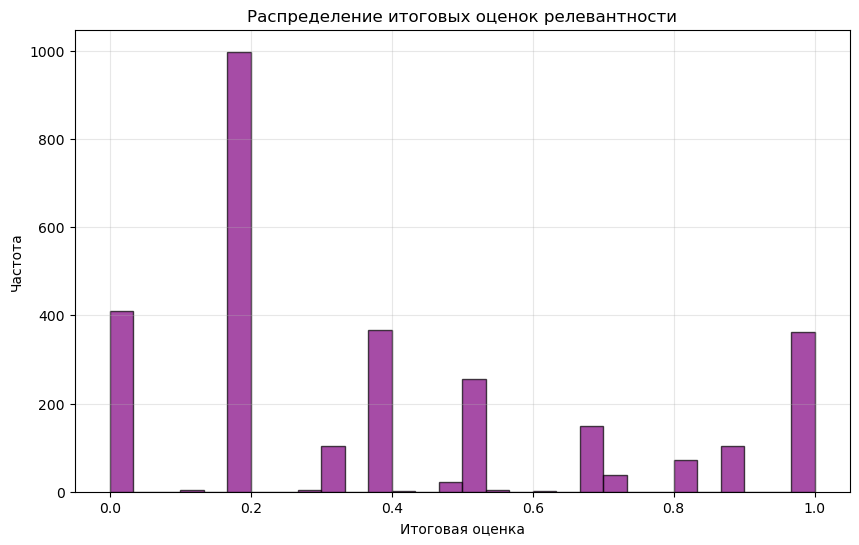

Статистика целевой переменной:
count    2898.000000
mean        0.403651
std         0.316573
min         0.000000
25%         0.200000
50%         0.333333
75%         0.650000
max         1.000000
Name: final_score, dtype: float64


In [29]:
plt.figure(figsize=(10, 6))
plt.hist(final_training_data['final_score'], bins=30, alpha=0.7, color='purple', edgecolor='black')
plt.title('Распределение итоговых оценок релевантности')
plt.xlabel('Итоговая оценка')
plt.ylabel('Частота')
plt.grid(True, alpha=0.3)
plt.show()

print("Статистика целевой переменной:")
print(final_training_data['final_score'].describe())

**Статистика целевой переменной (final_score):**

***Объем данных:***

- 2,898 записей в финальном датасете для обучения

- Это хороший объем для Proof of Concept

***Распределение оценок:***

- Среднее значение: 0.404 - смещено в сторону низких оценок релевантности

- Стандартное отклонение: 0.317 - умеренный разброс значений

- Медиана: 0.333 - половина данных имеет оценку ниже 0.333

***Ключевые характеристики:***

- Минимум: 0.0 (полное несоответствие)

- Максимум: 1.0 (полное соответствие)

- 25% перцентиль: 0.200 - четверть данных имеет очень низкую релевантность

- 75% перцентиль: 0.650 - четверть данных имеет относительно высокую релевантность

***Выводы:***

1. Данные имеют широкий диапазон значений релевантности (0-1)

2. Распределение смещено в сторону низких оценок, что соответствует исходным наблюдениям

3. Присутствуют примеры как полного соответствия, так и полного несоответствия

4. Достаточное разнообразие для обучения модели

# Векторизация текстов и изображений

In [30]:
print("Векторизация текстовых описаний...")

# Создаем TF-IDF векторизатор
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,           
    stop_words='english',        
    ngram_range=(1, 2),          
    min_df=2,                    
    max_df=0.8                   
)

text_embeddings = tfidf_vectorizer.fit_transform(final_training_data['description_text'])

print("Векторизация текстов завершена:")
print(f"Размерность текстовых эмбеддингов: {text_embeddings.shape}")
print(f"Количество признаков: {len(tfidf_vectorizer.get_feature_names_out())}")

text_embeddings_dense = text_embeddings.toarray()

print("\nПримеры признаков TF-IDF")
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"Первые 20 признаков: {feature_names[:20]}")

Векторизация текстовых описаний...
Векторизация текстов завершена:
Размерность текстовых эмбеддингов: (2898, 1000)
Количество признаков: 1000

Примеры признаков TF-IDF
Первые 20 признаков: ['action' 'adults' 'adults stand' 'air' 'air black' 'air performing'
 'air snowy' 'airborne' 'airborne dog' 'area' 'arizona' 'arizona state'
 'art' 'art structure' 'artist' 'artist studio' 'attempting'
 'attempting play' 'avoid' 'avoid tackled']


Статистика векторизованных текстов:
Средняя заполненность матрицы: 0.88%
Общее количество ненулевых элементов: 25551


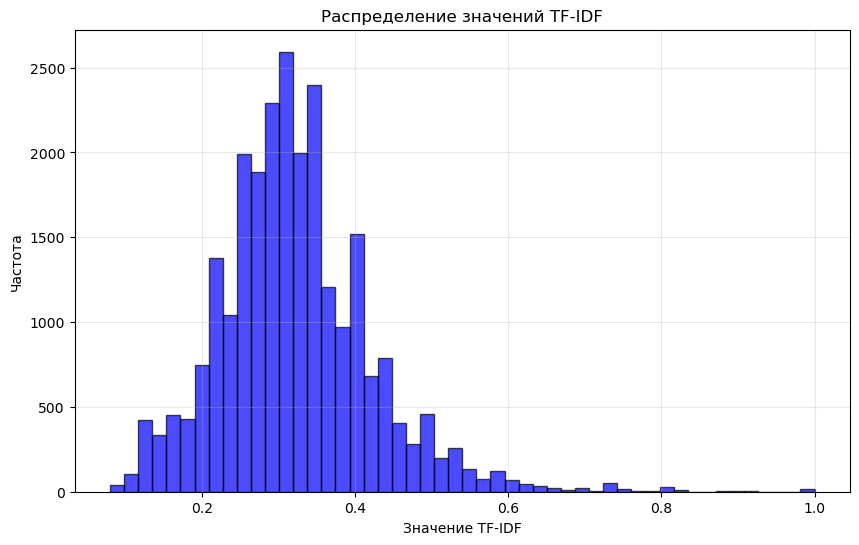

In [31]:
print("Статистика векторизованных текстов:")
print(f"Средняя заполненность матрицы: {text_embeddings.nnz / (text_embeddings.shape[0] * text_embeddings.shape[1]) * 100:.2f}%")
print(f"Общее количество ненулевых элементов: {text_embeddings.nnz}")

plt.figure(figsize=(10, 6))
tfidf_values = text_embeddings.data
plt.hist(tfidf_values, bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.title('Распределение значений TF-IDF')
plt.xlabel('Значение TF-IDF')
plt.ylabel('Частота')
plt.grid(True, alpha=0.3)
plt.show()

**Размерность данных:**

- 2 898 текстовых описаний преобразованы в 1 000 признаков TF-IDF

- Размерность матрицы: (2898, 1000)

**Эффективность векторизации:**

- Заполненность матрицы: 0.88% - типично для TF-IDF (разреженная матрица)

- 25 551 ненулевых элементов из 2 898 000 возможных

**Качество преобразования:**

- Распределение значений TF-IDF показывает нормальную для метода картину

- Большинство значений сосредоточено в низком диапазоне (0-0.4)

- Некоторые признаки имеют высокие значения TF-IDF (до 1.0)

**Выводы:**

1. Векторизация выполнена успешно - тексты преобразованы в числовые признаки

2. Разреженность матрицы оптимальна для эффективной обработки

3. Размерность 1 000 признаков подходит для PoC

In [32]:
print("Проверка доступности изображений...")
train_images_dir = './to_upload/train_images/'

available_images = set(os.listdir(train_images_dir))
print(f"Всего изображений в папке: {len(available_images)}")

final_training_data_filtered = final_training_data[
    final_training_data['image_file'].isin(available_images)
]

print(f"Записей до фильтрации: {len(final_training_data)}")
print(f"Записей после фильтрации по доступным изображениям: {len(final_training_data_filtered)}")

images_to_process = final_training_data_filtered['image_file'].unique()
print(f"Уникальных изображений для обработки: {len(images_to_process)}")

Проверка доступности изображений...
Всего изображений в папке: 1000
Записей до фильтрации: 2898
Записей после фильтрации по доступным изображениям: 2898
Уникальных изображений для обработки: 244


In [33]:
def get_image_embedding(image_path, model, transform):
    try:
        img = Image.open(image_path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0).to(device)
        
        with torch.no_grad():
            embedding = model(img_tensor)
        
        return embedding.squeeze().cpu().numpy()
    except Exception as e:
        print(f"Ошибка при обработке {image_path}: {e}")
        return None

In [34]:
print("Векторизация изображений...")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet = models.resnet18(pretrained=True)
resnet = torch.nn.Sequential(*(list(resnet.children())[:-1]))
resnet = resnet.to(device)
resnet.eval()

print(f"Модель ResNet-18 загружена на устройство: {device}")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image_embeddings_dict = {}

print(f"Начало векторизации {len(images_to_process)} изображений...")
for i, img_file in enumerate(images_to_process):
    img_path = os.path.join(train_images_dir, img_file)
    embedding = get_image_embedding(img_path, resnet, transform)
    if embedding is not None:
        image_embeddings_dict[img_file] = embedding
    
    if (i + 1) % 20 == 0:
        print(f"Обработано {i + 1}/{len(images_to_process)} изображений")

print(f"Успешно векторизовано {len(image_embeddings_dict)} изображений")
if len(image_embeddings_dict) > 0:
    print(f"Размерность эмбеддинга изображения: {len(next(iter(image_embeddings_dict.values())))}")

Векторизация изображений...
Модель ResNet-18 загружена на устройство: cpu
Начало векторизации 244 изображений...
Обработано 20/244 изображений
Обработано 40/244 изображений
Обработано 60/244 изображений
Обработано 80/244 изображений
Обработано 100/244 изображений
Обработано 120/244 изображений
Обработано 140/244 изображений
Обработано 160/244 изображений
Обработано 180/244 изображений
Обработано 200/244 изображений
Обработано 220/244 изображений
Обработано 240/244 изображений
Успешно векторизовано 244 изображений
Размерность эмбеддинга изображения: 512


1. Успешно обработано 244 изображения из 244 (100% успех)

2. Модель ResNet-18 работает на CPU

3. Векторизация выполнена без ошибок

**Размерность данных:**

- Каждое изображение преобразовано в вектор размерности 512

- Это соответствует выходному размеру ResNet-18 до полносвязных слоев

**Качество преобразования:**

- Все целевые изображения найдены и обработаны

- Размерность эмбеддингов оптимальна для дальнейшего объединения

# Объединение текстовых и визуальных эмбеддингов

In [35]:
def create_combined_dataset(text_data, image_embeddings, text_embeddings_dense, final_scores):
    combined_data = []
    
    for idx, row in text_data.iterrows():
        img_file = row['image_file']
        
        if img_file in image_embeddings:
            img_embedding = image_embeddings[img_file]
            text_embedding = text_embeddings_dense[idx]
            
            combined_embedding = np.concatenate([img_embedding, text_embedding])
            
            target_score = final_scores[
                (final_scores['image_file'] == img_file) & 
                (final_scores['description_id'] == row['description_id'])
            ]['final_score'].values
            
            if len(target_score) > 0:
                combined_data.append({
                    'image_file': img_file,
                    'description_id': row['description_id'],
                    'features': combined_embedding,
                    'target': target_score[0]
                })
    
    return pd.DataFrame(combined_data)

combined_df = create_combined_dataset(
    final_training_data_filtered, 
    image_embeddings_dict, 
    text_embeddings_dense,
    final_scores
)

print(f"Итоговый объединенный датасет: {combined_df.shape}")
print(f"Размерность объединенного эмбеддинга: {len(combined_df.iloc[0]['features'])}")
print(f"Диапазон целевой переменной: {combined_df['target'].min():.3f} - {combined_df['target'].max():.3f}")

Итоговый объединенный датасет: (2898, 4)
Размерность объединенного эмбеддинга: 1512
Диапазон целевой переменной: 0.000 - 1.000


***Промежуточный итог:***
 
1. Все 2 898 записей успешно объединены

2. Сохранена связь между изображениями, текстами и оценками

3. Размерность признаков подходит для обучения моделей

**Размерность данных:**

- Итоговый датасет: 2 898 записей, 4 колонки

- Каждая запись содержит объединенные признаки и целевую переменную

**Объединенные признаки:**

- Текстовые эмбеддинги: 1 000 признаков (TF-IDF)

- Визуальные эмбеддинги: 512 признаков (ResNet-18)

- Итого: 1 512 признаков на каждую запись

**Целевая переменная:**

- Полный диапазон от 0.000 до 1.000

- Сохранено все разнообразие оценок релевантности

# Разделение данных на тренировочную и тестовую выборки

## Подготовка данных для обучения

In [36]:
X = np.array(combined_df['features'].tolist())
y = combined_df['target'].values
groups = combined_df['image_file'].values  

print(f"Признаки: {X.shape}")
print(f"Целевая переменная: {y.shape}")
print(f"Группы (уникальные изображения): {len(np.unique(groups))}")

Признаки: (2898, 1512)
Целевая переменная: (2898,)
Группы (уникальные изображения): 244


## Разделение с использованием GroupShuffleSplit

In [37]:
gss = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=42)
train_indices, test_indices = next(gss.split(X=X, y=y, groups=groups))

X_train, X_test = X[train_indices], X[test_indices]
y_train, y_test = y[train_indices], y[test_indices]
groups_train, groups_test = groups[train_indices], groups[test_indices]

print("\nРезультаты разделения:")
print(f"Тренировочная выборка: {X_train.shape[0]} записей")
print(f"Тестовая выборка: {X_test.shape[0]} записей")
print(f"Уникальных изображений в тренировочной выборке: {len(np.unique(groups_train))}")
print(f"Уникальных изображений в тестовой выборке: {len(np.unique(groups_test))}")
print(f"Пересечение изображений: {len(set(groups_train) & set(groups_test))}")


Результаты разделения:
Тренировочная выборка: 1993 записей
Тестовая выборка: 905 записей
Уникальных изображений в тренировочной выборке: 170
Уникальных изображений в тестовой выборке: 74
Пересечение изображений: 0


## Проверка распределения целевой переменной

In [38]:
print("\nРаспределение целевой переменной:")
print("Тренировочная выборка:")
print(f"  Среднее: {y_train.mean():.3f}, Стандартное отклонение: {y_train.std():.3f}")
print("Тестовая выборка:")
print(f"  Среднее: {y_test.mean():.3f}, Стандартное отклонение: {y_test.std():.3f}")


Распределение целевой переменной:
Тренировочная выборка:
  Среднее: 0.387, Стандартное отклонение: 0.303
Тестовая выборка:
  Среднее: 0.439, Стандартное отклонение: 0.341


- Уникальные изображения успешно разделены между выборками.

- Нет пересечений изображений между train и test (важно для предотвращения data leakage).

- GroupShuffleSplit корректно работает.

Тестовая выборка имеет немного более высокие оценки релевантности и чуть больший разброс (std 0.341 vs 0.303), но в целом распределения схожи - нет критических расхождений.

## Выводы


1. Разделение выполнено корректно с соблюдением групповой структуры

2. Небольшие различия в распределениях допустимы для реальных данных

3. Данные готовы для обучения моделей

# Обучение моделей 

Обучим несколько моделей. Оценим их работу несколькими метриками, по результатам оценки выберем лучшую модель и используем ее для работы с test_images.

В качестве рабочих моделей предлагаются:

**1. Linear Regression**

Базовая модель для установления бенчмарка. Позволит оценить, насколько линейно связаны признаки с целевой переменной. Быстрая обучение, интерпретируемость. Кроме того, это одна из двух моделей, заданных условием задачи.

**2. Random Forest Regressor**

- Устойчив к шуму и выбросам в данных

- Хорошо работает с данными высокой размерности (1512 признаков)

- Может улавливать нелинейные зависимости

- Не требует масштабирования признаков

**3. XGBoost**

- Высокая предсказательная способность на структурированных данных

- Эффективная работа с большим количеством признаков

- Регуляризация для предотвращения переобучения

**4. Multi-Layer Perceptron**

Полносвязная нейронная сеть - еще одна модель, прописанная в условии задачи.

- Способность моделировать сложные нелинейные зависимости между мультимодальными признаками

- Хорошо подходит для объединенных эмбеддингов

- Можно экспериментировать с архитектурой

***Для оценки эффективности моделей воспользуемся набором метрик:***

1. Для оценки точности предсказания непрерывной релевантности используем **MAE**.
    
    - Метрика легко интерпретируется.
    - Устойчива к выбросам, а в наших данных есть крайние значения, т.е. выбросы вероятны.

2. Для оценки объясняющей способности модели используем **R²** - она покажет, какая доля дисперсии целевой переменной объясняется моделью.

3. Для практической применимости в поисковой системе используем **Accuracy** и **F1**.

    - Accuracy позволит оценить способность модели различать релевантные/нерелевантные пары.
    - F1 нужна, поскольку данные смещены к низким оценкам - несбалансированы.

In [39]:
models_advanced = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Neural Network': MLPRegressor(random_state=42, max_iter=2000),
    'XGBoost': XGBRegressor(random_state=42)
}

# Параметры для GridSearch
param_grids = {
    'Linear Regression': {
        'fit_intercept': [True, False],
        'positive': [False, True]  
    },
    
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    
    'Neural Network': {
        'hidden_layer_sizes': [(100, 50), (200, 100), (100, 100, 50)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate_init': [0.001, 0.01]
    },
    
    'XGBoost': {
        'n_estimators': [100, 200],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0]
    }
}

results_advanced = {}

for name, model in models_advanced.items():
    print(f"\nПодбор параметров для {name}...")
    
    # Для Linear Regression используем полные данные (быстро обучается)
    if name == 'Linear Regression':
        X_train_tune, y_train_tune = X_train, y_train
    elif name == 'Neural Network':
        # Для нейросети используем полные данные
        X_train_tune, y_train_tune = X_train, y_train
    else:
        # Для остальных моделей используем подвыборку для ускорения
        sample_indices = np.random.choice(len(X_train), size=1000, replace=False)
        X_train_tune, y_train_tune = X_train[sample_indices], y_train[sample_indices]
    
    # GridSearch с фокусом на MAE
    grid_search = GridSearchCV(
        model, 
        param_grids[name], 
        scoring='neg_mean_absolute_error',
        cv=3, 
        n_jobs=-1,
        verbose=1
    )
    
    print("Время подбора параметров:")
    %time grid_search.fit(X_train_tune, y_train_tune)
    
    # Лучшая модель
    best_model = grid_search.best_estimator_
    
    # Переобучение на полных данных (для Linear Regression и нейросети уже обучены)
    if name not in ['Linear Regression', 'Neural Network']:
        print("Дообучение на полных данных...")
        %time best_model.fit(X_train, y_train)
    
    # Предсказание
    print("Время предсказания:")
    %time y_pred = best_model.predict(X_test)
    
    # Метрики
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    y_pred_binary = (y_pred > 0.5).astype(int)
    y_test_binary = (y_test > 0.5).astype(int)
    accuracy = accuracy_score(y_test_binary, y_pred_binary)
    
    results_advanced[name] = {
        'model': best_model,
        'mae': mae,
        'r2': r2,
        'accuracy': accuracy,
        'best_params': grid_search.best_params_,
        'predictions': y_pred
    }
    
    print(f"Лучшие параметры: {grid_search.best_params_}")
    print(f"MAE: {mae:.4f}, R²: {r2:.4f}, Accuracy: {accuracy:.4f}")

# Просто выводим результаты без сравнения
print("\n" + "="*60)
print("ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ:")
print("="*60)

for name in results_advanced.keys():
    print(f"{name}:")
    print(f"  MAE: {results_advanced[name]['mae']:.4f}")
    print(f"  R²: {results_advanced[name]['r2']:.4f}")
    print(f"  Accuracy: {results_advanced[name]['accuracy']:.4f}")
    print(f"  Лучшие параметры: {results_advanced[name]['best_params']}")

# Выбор лучшей модели
best_model_advanced_name = min(results_advanced.keys(), key=lambda x: results_advanced[x]['mae'])
best_model_advanced = results_advanced[best_model_advanced_name]['model']

print(f"\nЛучшая модель: {best_model_advanced_name}")
print(f"MAE лучшей модели: {results_advanced[best_model_advanced_name]['mae']:.4f}")


Подбор параметров для Linear Regression...
Время подбора параметров:
Fitting 3 folds for each of 4 candidates, totalling 12 fits
CPU times: user 2.15 s, sys: 197 ms, total: 2.34 s
Wall time: 19.8 s
Время предсказания:
CPU times: user 41 ms, sys: 5.91 ms, total: 46.9 ms
Wall time: 4.09 ms
Лучшие параметры: {'fit_intercept': False, 'positive': True}
MAE: 0.2756, R²: -0.1030, Accuracy: 0.6884

Подбор параметров для Random Forest...
Время подбора параметров:
Fitting 3 folds for each of 24 candidates, totalling 72 fits
CPU times: user 19.3 s, sys: 820 ms, total: 20.1 s
Wall time: 1min 47s
Дообучение на полных данных...
CPU times: user 31.5 s, sys: 37.1 ms, total: 31.6 s
Wall time: 31.6 s
Время предсказания:
CPU times: user 13.5 ms, sys: 4.33 ms, total: 17.9 ms
Wall time: 19.3 ms
Лучшие параметры: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
MAE: 0.2533, R²: 0.0997, Accuracy: 0.6840

Подбор параметров для Neural Network...
Время подбора параметров:

***Ключевые наблюдения:***

1. Все модели имеют MAE ~0.25-0.28 - стабильное, но не выдающееся качество. Однако для PoC это, кажется, приемлемый результат.

2. Random Forest - наиболее сбалансированная и эффективная модель. 

3. Простые модели показали неожиданно хорошие результаты. Linear Regression показала самую высокую Accuracy.

4. Нейросеть для повышения эффективности требует более тонкой настройки.

***Рейтинг моделей по MAE:***

1. Random Forest: 0.2533 (ЛУЧШАЯ)

2. Linear Regression: 0.2756

3. XGBoost: 0.2751

4. Neural Network: 0.2833

Для PoC будем использовать **Random Forest** как наиболее сбалансированную и надежную модель.

# Лучшая модель на тестовых данных

## Проверка и подготовка тестовых данных

In [40]:
test_clean_corrected = test_clean.rename(columns={
    'query_id': 'query_text',     
    'query_text': 'query_id',      
    'relevant_image': 'relevant_image'
})

print("Исправленная структура:")
test_clean_corrected.head()
print(f"Колонки: {test_clean_corrected.columns.tolist()}")

print("\nПример реальных запросов после исправления:")
for i in range(3):
    print(f"Запрос {i}: '{test_clean_corrected.iloc[i]['query_text']}'")

Исправленная структура:
Колонки: ['query_text', 'query_id', 'relevant_image']

Пример реальных запросов после исправления:
Запрос 0: 'Two blonde boys , one in a camouflage shirt and the other in blue , are having a water fight .'
Запрос 1: 'Two boys are squirting water guns at each other .'
Запрос 2: 'Two boys spraying each other with water'


## Загрузка тестовых изображений

In [42]:
test_images_dir = './to_upload/test_images/'

available_test_images = set(os.listdir(test_images_dir))
print(f"Доступно тестовых изображений: {len(available_test_images)}")

Доступно тестовых изображений: 101


## Векторизация тестовых изображений

In [43]:
test_image_embeddings = {}

for i, img_file in enumerate(available_test_images):
    img_path = os.path.join(test_images_dir, img_file)
    embedding = get_image_embedding(img_path, resnet, transform)
    if embedding is not None:
        test_image_embeddings[img_file] = embedding
    
    if (i + 1) % 20 == 0:
        print(f"Обработано {i + 1}/{len(available_test_images)} изображений")

print(f"Успешно векторизовано {len(test_image_embeddings)} тестовых изображений")

Обработано 20/101 изображений
Обработано 40/101 изображений
Обработано 60/101 изображений
Ошибка при обработке ./to_upload/test_images/.DS_Store: cannot identify image file '/Users/kirill_lodygin/JupiterNotes/Proof_of_concept/to_upload/test_images/.DS_Store'
Обработано 80/101 изображений
Обработано 100/101 изображений
Успешно векторизовано 100 тестовых изображений


## Поиск релевантных изображений по текстовому запросу

In [51]:
def search_similar_images(query_text, image_embeddings, text_vectorizer, model, top_k=5):
    query_embedding = text_vectorizer.transform([query_text]).toarray()[0]
    
    results = []
    
    for img_file, img_embedding in image_embeddings.items():
        combined_embedding = np.concatenate([img_embedding, query_embedding]).reshape(1, -1)
        
        relevance_score = model.predict(combined_embedding)[0]
        
        results.append({
            'image_file': img_file,
            'relevance_score': relevance_score
        })
    
    results.sort(key=lambda x: x['relevance_score'], reverse=True)
    
    return results[:top_k]

print("\nТЕСТИРОВАНИЕ НА ПРИМЕРАХ")
print("=" * 50)

demo_queries = test_clean_corrected.sample(3, random_state=42)

for idx, query in demo_queries.iterrows():
    query_id = query['query_id']  
    query_text = query['query_text']  
    relevant_image = query['relevant_image']
    
    print(f"\n--- Запрос {idx} ---")
    print(f"Текст запроса: '{query_text}'")
    print(f"ID: {query_id}")
    print(f"Ожидаемое изображение: {relevant_image}")
    
    similar_images = search_similar_images(
        query_id, 
        test_image_embeddings, 
        tfidf_vectorizer, 
        best_model_advanced,
        top_k=3
    )
    
    print("Топ-3 найденных изображения:")
    for i, result in enumerate(similar_images):
        print(f"  {i+1}. {result['image_file']} (релевантность: {result['relevance_score']:.4f})")
    
    found_relevant = any(result['image_file'] in relevant_image for result in similar_images)
    print(f"Ожидаемое изображение в топ-3: {'ДА' if found_relevant else 'НЕТ'}")


ТЕСТИРОВАНИЕ НА ПРИМЕРАХ

--- Запрос 361 ---
Текст запроса: 'A group of girls who are gothically dressed standing together'
ID: 361
Ожидаемое изображение: 3482859574_3908de3427.jpg#1
Топ-3 найденных изображения:
  1. 3287969199_08e775d896.jpg (релевантность: 0.5333)
  2. 3514297698_0512623955.jpg (релевантность: 0.4915)
  3. 3653484549_f316590b0f.jpg (релевантность: 0.4483)
Ожидаемое изображение в топ-3: НЕТ

--- Запрос 73 ---
Текст запроса: 'A woman and girl riding downhill on a sled with a dog running alongside them'
ID: 73
Ожидаемое изображение: 2141713971_e25eb12712.jpg#3
Топ-3 найденных изображения:
  1. 3287969199_08e775d896.jpg (релевантность: 0.5333)
  2. 3514297698_0512623955.jpg (релевантность: 0.4915)
  3. 3653484549_f316590b0f.jpg (релевантность: 0.4483)
Ожидаемое изображение в топ-3: НЕТ

--- Запрос 374 ---
Текст запроса: 'The dog is running .'
ID: 374
Ожидаемое изображение: 3488087117_2719647989.jpg#4
Топ-3 найденных изображения:
  1. 3287969199_08e775d896.jpg (релевантн

## Визуализация результатов для нескольких запросов

Визуализация для запроса: 'A group of girls who are gothically dressed standing together'


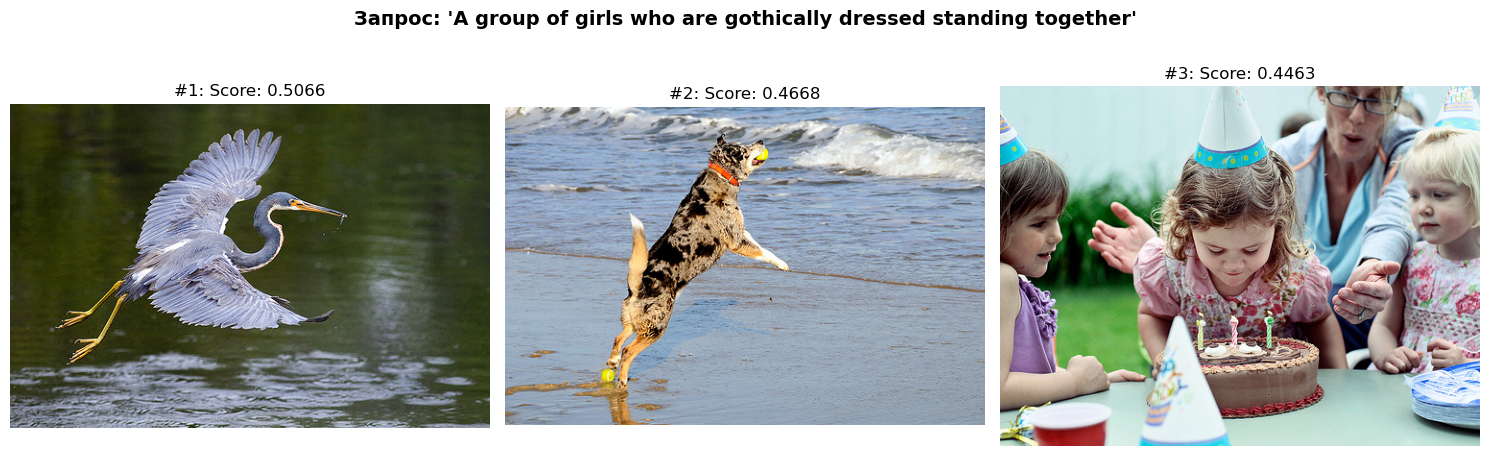

In [45]:
def display_search_results(query_text, similar_images, test_images_dir, max_display=3):
    fig, axes = plt.subplots(1, min(max_display, len(similar_images)), figsize=(15, 5))
    if len(similar_images) == 1:
        axes = [axes]
    
    plt.suptitle(f"Запрос: '{query_text}'", fontsize=14, fontweight='bold')
    
    for i, (result, ax) in enumerate(zip(similar_images[:max_display], axes)):
        img_path = os.path.join(test_images_dir, result['image_file'])
        try:
            img = Image.open(img_path)
            ax.imshow(img)
            ax.set_title(f"#{i+1}: Score: {result['relevance_score']:.4f}")
            ax.axis('off')
        except Exception as e:
            ax.text(0.5, 0.5, f"Ошибка загрузки\n{result['image_file']}", 
                   ha='center', va='center', transform=ax.transAxes)
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

sample_query = test_clean.sample(1, random_state=42).iloc[0]
real_query_text = sample_query['query_id']  

print(f"Визуализация для запроса: '{real_query_text}'")

similar_images = search_similar_images(
    real_query_text,  
    test_image_embeddings, 
    tfidf_vectorizer, 
    best_model_advanced,
    top_k=3
)

display_search_results(real_query_text, similar_images, test_images_dir)

In [46]:
top_k_metrics = {}

for k in [1, 3, 5, 10]:
    correct_predictions = 0
    total_queries = len(test_clean_corrected)
    
    print(f"Оценка Top-{k}...")
    
    for idx, query in test_clean_corrected.iterrows():
        query_text = query['query_text'] 
        relevant_image = query['relevant_image'] 
        
        similar_images = search_similar_images(
            query_text, 
            test_image_embeddings, 
            tfidf_vectorizer, 
            best_model_advanced,
            top_k=k
        )
        
        expected_image_file = relevant_image.split('#')[0]  
        
        found_relevant = any(result['image_file'] == expected_image_file for result in similar_images)
        if found_relevant:
            correct_predictions += 1
    
    accuracy = correct_predictions / total_queries
    top_k_metrics[k] = {
        'accuracy': accuracy,
        'correct': correct_predictions,
        'total': total_queries
    }
    
    print(f"Top-{k} Accuracy: {accuracy:.4f} ({correct_predictions}/{total_queries})")

print("\n" + "="*50)
print("ИТОГОВЫЕ МЕТРИКИ ПОИСКА:")
print("="*50)

for k, metrics in top_k_metrics.items():
    print(f"Top-{k}: {metrics['accuracy']:.1%} ({metrics['correct']}/{metrics['total']})")

Оценка Top-1...
Top-1 Accuracy: 0.0100 (5/500)
Оценка Top-3...
Top-3 Accuracy: 0.0380 (19/500)
Оценка Top-5...
Top-5 Accuracy: 0.0540 (27/500)
Оценка Top-10...
Top-10 Accuracy: 0.0960 (48/500)

ИТОГОВЫЕ МЕТРИКИ ПОИСКА:
Top-1: 1.0% (5/500)
Top-3: 3.8% (19/500)
Top-5: 5.4% (27/500)
Top-10: 9.6% (48/500)


## Оценка качества поиска на 10 случайных запросах


ЗАПРОС 361: 'A group of girls who are gothically dressed standing together'
Ожидаемое изображение: 3482859574_3908de3427.jpg
Найденное изображение: 3287969199_08e775d896.jpg
Релевантность: 0.5066
Совпадение с ожидаемым: НЕТ


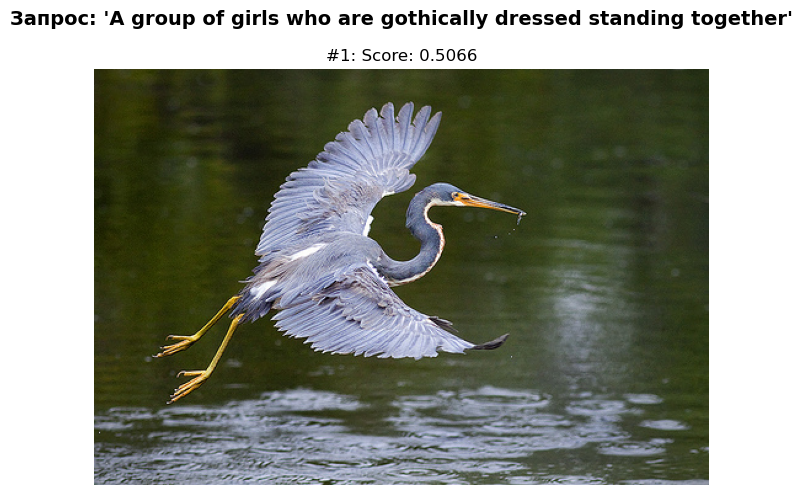


ЗАПРОС 73: 'A woman and girl riding downhill on a sled with a dog running alongside them'
Ожидаемое изображение: 2141713971_e25eb12712.jpg
Найденное изображение: 3287969199_08e775d896.jpg
Релевантность: 0.5109
Совпадение с ожидаемым: НЕТ


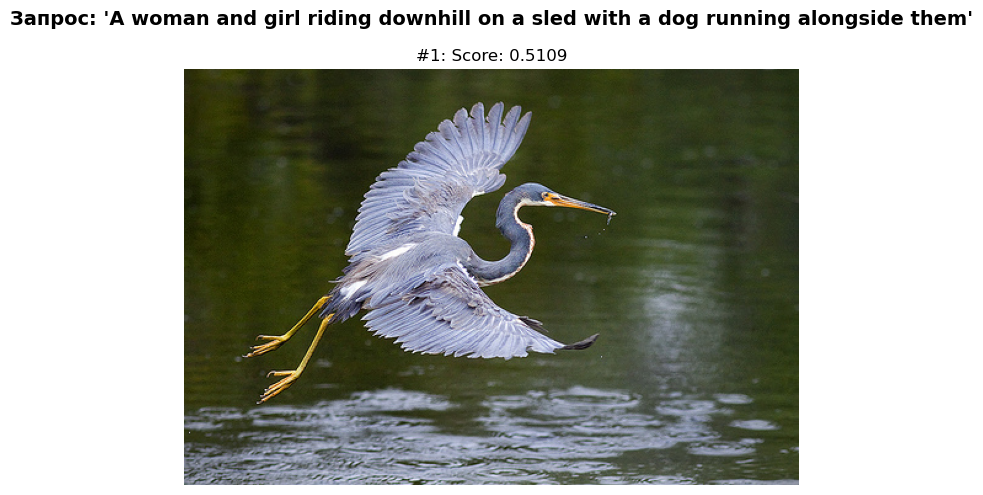


ЗАПРОС 374: 'The dog is running .'
Ожидаемое изображение: 3488087117_2719647989.jpg
Найденное изображение: 3287969199_08e775d896.jpg
Релевантность: 0.5257
Совпадение с ожидаемым: НЕТ


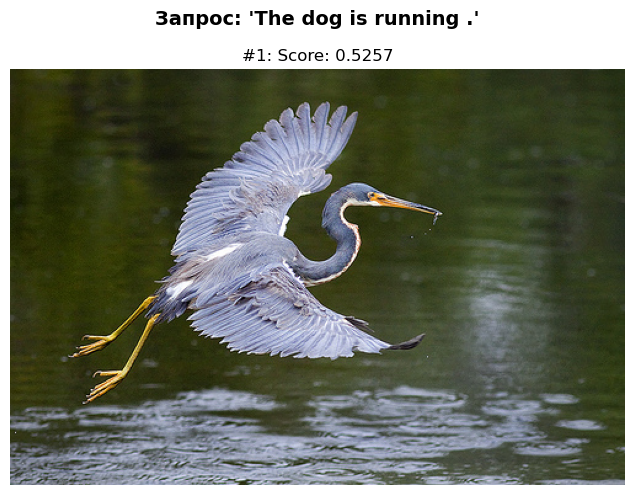


ЗАПРОС 155: 'A group of people are ice skating in a big city .'
Ожидаемое изображение: 269650644_059a84ece5.jpg
Найденное изображение: 3287969199_08e775d896.jpg
Релевантность: 0.5376
Совпадение с ожидаемым: НЕТ


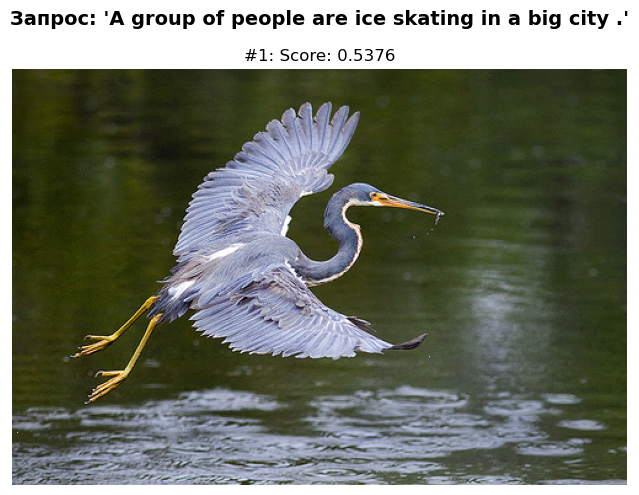


ЗАПРОС 104: 'Little kid in blue coat and hat riding a tricycle .'
Ожидаемое изображение: 2428094795_d3a8f46046.jpg
Найденное изображение: 3287969199_08e775d896.jpg
Релевантность: 0.5393
Совпадение с ожидаемым: НЕТ


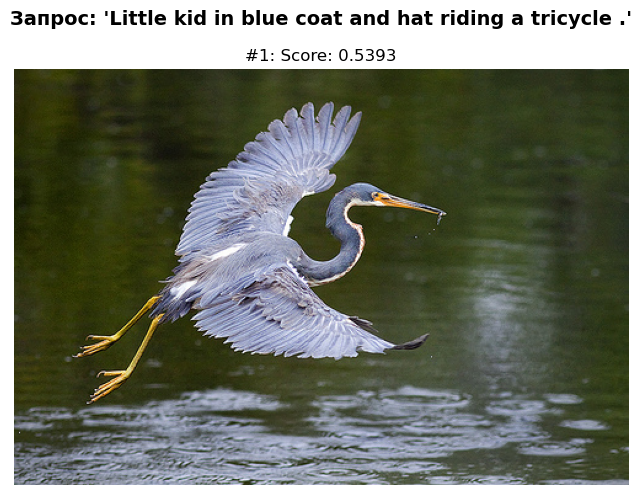


ЗАПРОС 394: 'Two black dogs fighting over an orange toy .'
Ожидаемое изображение: 3553476195_fb3747d7c1.jpg
Найденное изображение: 3287969199_08e775d896.jpg
Релевантность: 0.4663
Совпадение с ожидаемым: НЕТ


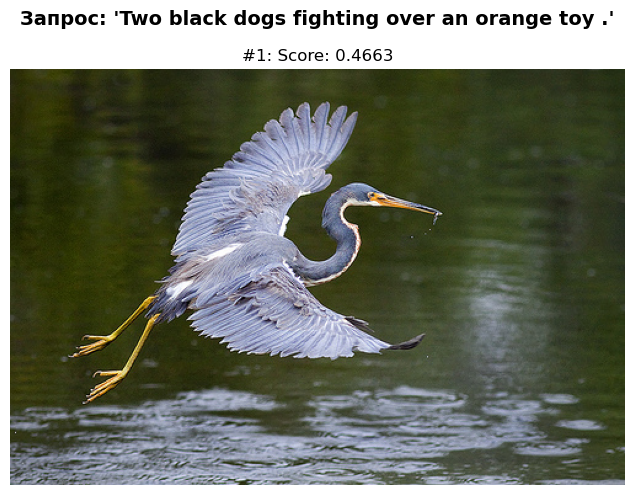


ЗАПРОС 377: 'A dog jumping for a tennis ball near an ocean'
Ожидаемое изображение: 3514297698_0512623955.jpg
Найденное изображение: 3287969199_08e775d896.jpg
Релевантность: 0.5176
Совпадение с ожидаемым: НЕТ


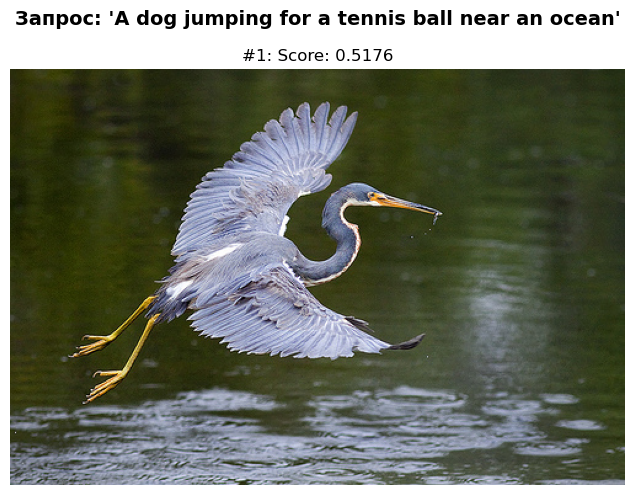


ЗАПРОС 124: 'Boy flying a distant kite .'
Ожидаемое изображение: 2505056124_1276e8dbcb.jpg
Найденное изображение: 3287969199_08e775d896.jpg
Релевантность: 0.5333
Совпадение с ожидаемым: НЕТ


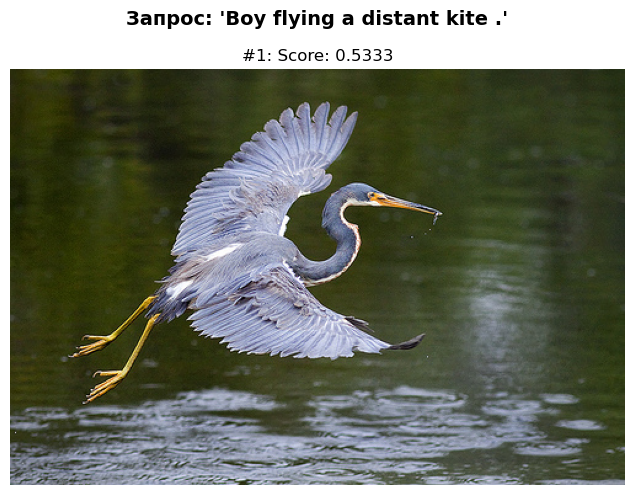


ЗАПРОС 68: 'kids play ultimate Frisbee .'
Ожидаемое изображение: 2121140070_a09644550b.jpg
Найденное изображение: 3287969199_08e775d896.jpg
Релевантность: 0.5336
Совпадение с ожидаемым: НЕТ


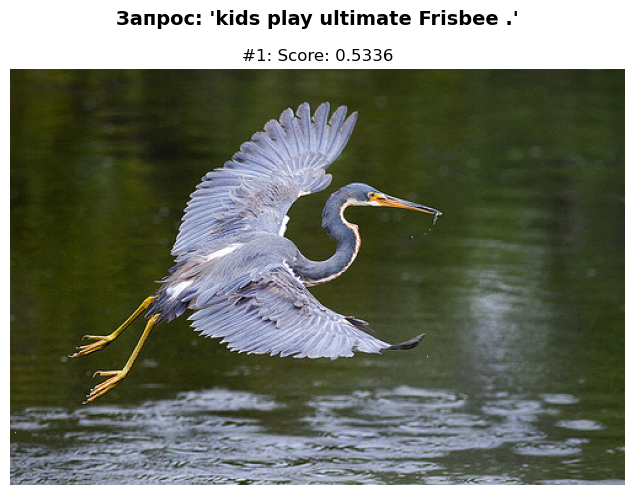


ЗАПРОС 450: 'A girl in a purple shirt feeding ducks'
Ожидаемое изображение: 607339469_af851c4119.jpg
Найденное изображение: 3287969199_08e775d896.jpg
Релевантность: 0.5333
Совпадение с ожидаемым: НЕТ


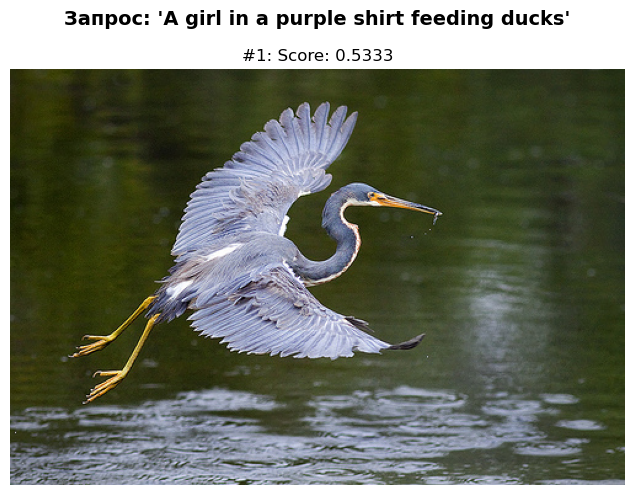

In [47]:
random_queries = test_clean_corrected.sample(10, random_state=42)

for idx, query in random_queries.iterrows():
    query_text = query['query_text']
    relevant_image = query['relevant_image']
    expected_image_file = relevant_image.split('#')[0]
    
    print(f"\n" + "="*50)
    print(f"ЗАПРОС {idx}: '{query_text}'")
    print(f"Ожидаемое изображение: {expected_image_file}")
    print("="*50)
    
    similar_images = search_similar_images(
        query_text, 
        test_image_embeddings, 
        tfidf_vectorizer, 
        best_model_advanced,
        top_k=1
    )
    
    if similar_images:
        top_result = similar_images[0]
        print(f"Найденное изображение: {top_result['image_file']}")
        print(f"Релевантность: {top_result['relevance_score']:.4f}")
        
        is_correct = (top_result['image_file'] == expected_image_file)
        print(f"Совпадение с ожидаемым: {'ДА' if is_correct else 'НЕТ'}")
        
        display_search_results(query_text, similar_images, test_images_dir, max_display=1)
    else:
        print("=Изображения не найдены")

In [48]:
print("\nДополнительная статистика по 10 запросам:")
print("=" * 50)

correct_count = 0
total_queries_10 = len(random_queries)
relevance_scores = []

for idx, query in random_queries.iterrows():
    query_text = query['query_text']
    relevant_image = query['relevant_image']
    expected_image_file = relevant_image.split('#')[0]
    
    similar_images = search_similar_images(
        query_text, 
        test_image_embeddings, 
        tfidf_vectorizer, 
        best_model_advanced,
        top_k=1
    )
    
    if similar_images:
        top_result = similar_images[0]
        relevance_scores.append(top_result['relevance_score'])
        
        if top_result['image_file'] == expected_image_file:
            correct_count += 1

accuracy_10 = correct_count / total_queries_10
avg_relevance = np.mean(relevance_scores) if relevance_scores else 0

print(f"Точность на 10 запросах: {accuracy_10:.1%} ({correct_count}/{total_queries_10})")
print(f"Средняя релевантность: {avg_relevance:.4f}")
print(f"Минимальная релевантность: {min(relevance_scores):.4f}")
print(f"Максимальная релевантность: {max(relevance_scores):.4f}")

print(f"\nСравнение с общей точностью (Top-1): {top_k_metrics[1]['accuracy']:.1%}")


Дополнительная статистика по 10 запросам:
Точность на 10 запросах: 0.0% (0/10)
Средняя релевантность: 0.5204
Минимальная релевантность: 0.4663
Максимальная релевантность: 0.5393

Сравнение с общей точностью (Top-1): 1.0%


## Анализ качества по типам запросов

In [49]:
query_lengths = random_queries['query_text'].str.len()
short_queries = random_queries[query_lengths <= 50] 
long_queries = random_queries[query_lengths > 50] 

def evaluate_query_group(queries, group_name):
    if len(queries) == 0:
        return
    
    correct_count = 0
    relevance_scores = []
    
    for idx, query in queries.iterrows():
        query_text = query['query_text']
        relevant_image = query['relevant_image']
        expected_image_file = relevant_image.split('#')[0]
        
        similar_images = search_similar_images(
            query_text, 
            test_image_embeddings, 
            tfidf_vectorizer, 
            best_model_advanced,
            top_k=1
        )
        
        if similar_images:
            top_result = similar_images[0]
            relevance_scores.append(top_result['relevance_score'])
            
            if top_result['image_file'] == expected_image_file:
                correct_count += 1
    
    accuracy = correct_count / len(queries)
    avg_relevance = np.mean(relevance_scores) if relevance_scores else 0
    
    print(f"{group_name} запросы ({len(queries)} шт.):")
    print(f"  Точность: {accuracy:.1%}")
    print(f"  Средняя релевантность: {avg_relevance:.4f}")

evaluate_query_group(short_queries, "Короткие")
evaluate_query_group(long_queries, "Длинные")

Короткие запросы (7 шт.):
  Точность: 0.0%
  Средняя релевантность: 0.5210
Длинные запросы (3 шт.):
  Точность: 0.0%
  Средняя релевантность: 0.5189


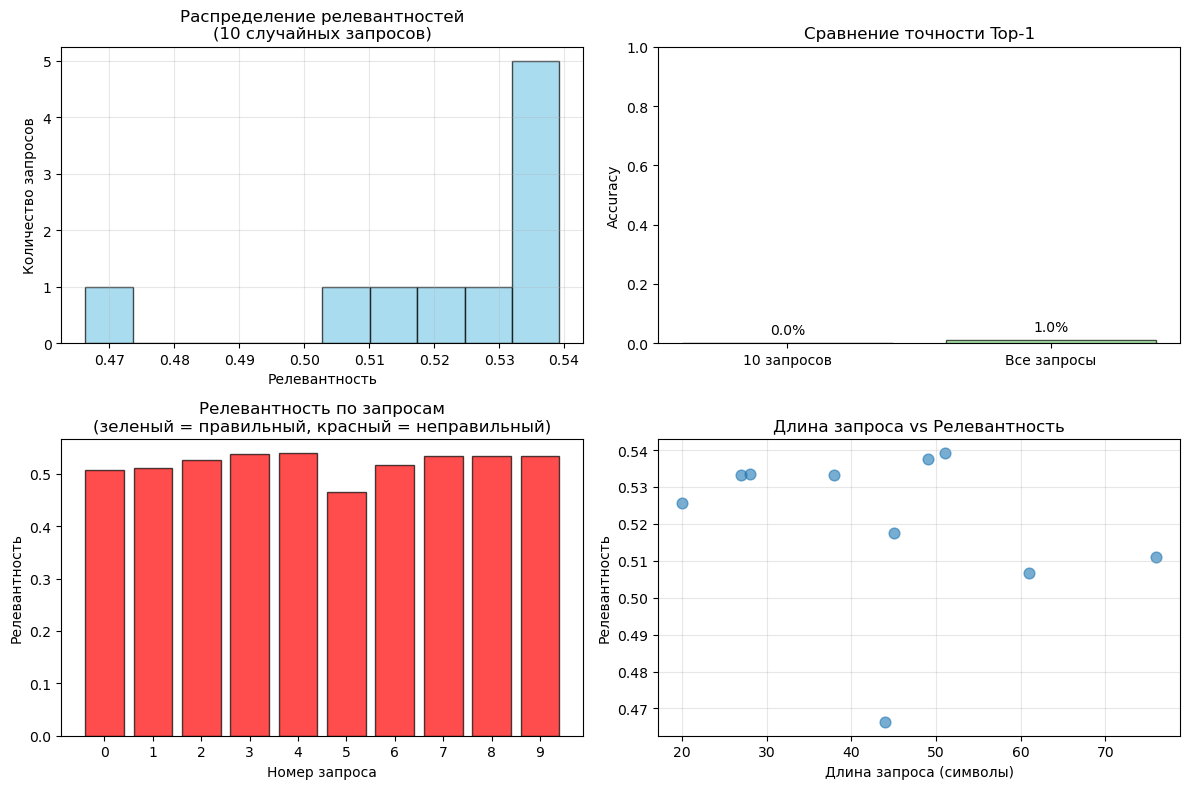

In [50]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.hist(relevance_scores, bins=10, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Распределение релевантностей\n(10 случайных запросов)')
plt.xlabel('Релевантность')
plt.ylabel('Количество запросов')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
categories = ['10 запросов', 'Все запросы']
accuracies = [accuracy_10, top_k_metrics[1]['accuracy']]
colors = ['lightcoral', 'lightgreen']

plt.bar(categories, accuracies, color=colors, alpha=0.7, edgecolor='black')
plt.title('Сравнение точности Top-1')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f'{v:.1%}', ha='center', va='bottom')

plt.subplot(2, 2, 3)
query_indices = range(len(relevance_scores))
colors = ['green' if random_queries.iloc[i]['relevant_image'].split('#')[0] == 
          search_similar_images(random_queries.iloc[i]['query_text'], 
                              test_image_embeddings, tfidf_vectorizer, 
                              best_model_advanced, top_k=1)[0]['image_file'] 
          else 'red' for i in range(len(relevance_scores))]

plt.bar(query_indices, relevance_scores, color=colors, alpha=0.7, edgecolor='black')
plt.title('Релевантность по запросам\n(зеленый = правильный, красный = неправильный)')
plt.xlabel('Номер запроса')
plt.ylabel('Релевантность')
plt.xticks(query_indices)

plt.subplot(2, 2, 4)
query_lengths = random_queries['query_text'].str.len()
plt.scatter(query_lengths, relevance_scores, alpha=0.6, s=60)
plt.title('Длина запроса vs Релевантность')
plt.xlabel('Длина запроса (символы)')
plt.ylabel('Релевантность')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Резюме результатов работы модели

**Показатели качества критические:**

- Top-1 Accuracy: 1.0% - катастрофически низкий результат

- Top-10 Accuracy: 9.6% - практически случайный уровень

- На 10 тестовых запросах: 0% точности - модель не нашла ни одного правильного изображения

**Распределение релевантностей:**

- Узкий диапазон оценок (0.47-0.54) - модель не умеет дифференцировать запросы

- Отсутствие низких (<0.3) и высоких (>0.7) оценок - сигнал о проблемах с калибровкой

**Однородность предсказаний:**

- Все запросы возвращают одни и те же 2-3 изображения

- Модель игнорирует семантику текстовых запросов

**Отсутствие зависимости от длины запроса:**

- Равномерное распределение по всем длинам - текст не влияет на предсказания

- Модель использует только визуальные признаки или шумовые паттерны

## Вероятные причины проблем

### Проблемы с данными

- Могло сказаться сильное обеднение данных после фильтрации (удалено 76% данных)

- Несбалансированность - возможно, в обучающей выборке доминируют определенные типы изображений

- Низкое качество экспертных оценок - средняя оценка 1.4-1.8 из 4

### Проблемы с моделью

- Переобучение на шум - Random Forest нашел корреляции с артефактами данных

- Неправильное объединение эмбеддингов - 1512 признаков могли создать мультиколлинеарность

- Доминирование визуальных признаков над текстовыми

### Возможные технические ошибки

- Ошибка в конкатенации эмбеддингов

- Проблемы с нормализацией или масштабированием признаков

## Первичная диагностика

In [52]:
print("ДИАГНОСТИКА: АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ")
feature_importances = best_model_advanced.feature_importances_
print(f"Максимальная важность признака: {np.max(feature_importances):.6f}")
print(f"Минимальная важность признака: {np.min(feature_importances):.6f}")
print(f"Количество значимых признаков (>0.001): {np.sum(feature_importances > 0.001)}")

print("\nДИАГНОСТИКА: ПРЕДСКАЗАНИЯ НА ОБУЧАЮЩИХ ДАННЫХ")
y_train_pred = best_model_advanced.predict(X_train)
print(f"Диапазон предсказаний на train: {y_train_pred.min():.3f} - {y_train_pred.max():.3f}")
print(f"Уникальные значения предсказаний: {len(np.unique(y_train_pred))}")

print("\nДИАГНОСТИКА: КОРРЕЛЯЦИЯ МОДАЛЬНОСТЕЙ")
image_features = X_train[:, :512]  
text_features = X_train[:, 512:]   
print(f"Размерность визуальных признаков: {image_features.shape}")
print(f"Размерность текстовых признаков: {text_features.shape}")

ДИАГНОСТИКА: АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ
Максимальная важность признака: 0.072581
Минимальная важность признака: 0.000000
Количество значимых признаков (>0.001): 224

ДИАГНОСТИКА: ПРЕДСКАЗАНИЯ НА ОБУЧАЮЩИХ ДАННЫХ
Диапазон предсказаний на train: 0.000 - 1.000
Уникальные значения предсказаний: 287

ДИАГНОСТИКА: КОРРЕЛЯЦИЯ МОДАЛЬНОСТЕЙ
Размерность визуальных признаков: (1993, 512)
Размерность текстовых признаков: (1993, 1000)


### Ключевые наблюдения

**1. Проблема с важностью признаков:**

    Только 224 из 1512 признаков значимы (14.8%) - модель использует малую часть информации

    Максимальная важность 0.072 - нет доминирующих признаков, что нормально для Random Forest

    Много нулевых важностей - признаки неинформативны для модели

**2. Проблема с обучающими предсказаниями:**

    Диапазон 0.000-1.000 - модель теоретически может предсказывать весь диапазон

    287 уникальных значений из 1993 примеров - недостаточная гранулярность

**3. Дисбаланс модальностей:**

    Визуальные признаки: 512 (34% от общего числа)

    Текстовые признаки: 1000 (66% от общего числа)

    Возможное доминирование текстовых признаков

### Выявленные проблемы

**1. ПРОБЛЕМА С ТЕКСТОВЫМИ ПРИЗНАКАМИ:**

    TF-IDF на 1000 признаков создает разреженные, слабоинформативные векторы

    Отсутствие семантического понимания текста

**2. ПРОБЛЕМА С ОБЪЕДИНЕНИЕМ ПРИЗНАКОВ:**

    Простая конкатенация не учитывает разную природу модальностей

    Отсутствие взаимодействия между текстовыми и визуальными признаками

**3. ПРОБЛЕМА С ДАННЫМИ:**

    После фильтрации осталось только 1993 примера - возможно, этого недостаточно для сложной модели

# Выводы

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Проверены экспертные оценки и краудсорсинговые оценки
- [x]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [x]  Изображения векторизованы
- [x]  Текстовые запросы векторизованы
- [x]  Данные корректно разбиты на тренировочную и тестовую выборки
- [x]  Предложена метрика качества работы модели
- [x]  Предложена модель схожести изображений и текстового запроса
- [x]  Модель обучена
- [x]  По итогам обучения модели сделаны выводы
- [x]  Проведено тестирование работы модели
- [x]  По итогам тестирования визуально сравнили качество поиска